In [1]:
#import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
%pylab inline
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from sklearn.cluster import DBSCAN

Populating the interactive namespace from numpy and matplotlib


# Waiter Tips Prediction

In [2]:
#load dataset
df_waiter = pd.read_csv('tips.csv')

In [3]:
#show 5 rows ahead of dataset
df_waiter.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


## Exploratory Data Analysis (EDA)

In [4]:
#check total rows and total columns
df_waiter.shape

(244, 7)

In [5]:
#check missing value
df_waiter.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

In [6]:
#check info about dataset
df_waiter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [7]:
#describe dataset
df_waiter.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


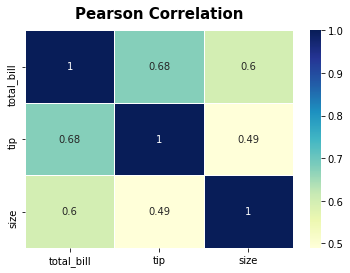

In [8]:
#visualize correlation of each variables using pearson correlation
sns.heatmap(df_waiter.corr(), linewidths = 0.9, annot = True, cmap = 'YlGnBu')
plt.title('Pearson Correlation', fontsize = 15, pad = 12, fontweight = 'bold')
plt.show()

In [9]:
#check unique of sex column
df_waiter['sex'].unique()

array(['Female', 'Male'], dtype=object)

In [10]:
#check unique of smoker column
df_waiter['smoker'].unique()

array(['No', 'Yes'], dtype=object)

In [11]:
#check unique of day column
df_waiter['day'].unique()

array(['Sun', 'Sat', 'Thur', 'Fri'], dtype=object)

In [12]:
#check unique of time column
df_waiter['time'].unique()

array(['Dinner', 'Lunch'], dtype=object)

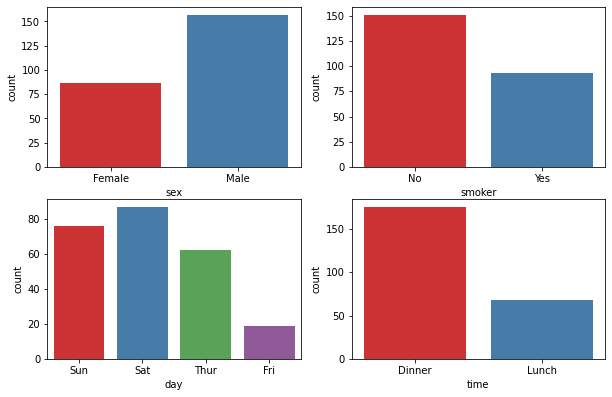

In [13]:
#visualize number of each attributes of dataset
fig = plt.figure(figsize = (10,10))
axes = 320

for i in df_waiter[['sex', 'smoker', 'day', 'time']]:
    axes += 1
    fig.add_subplot(axes)
    sns.countplot(data = df_waiter, x = i, palette = 'Set1')
    plt.xticks()
    
plt.show()

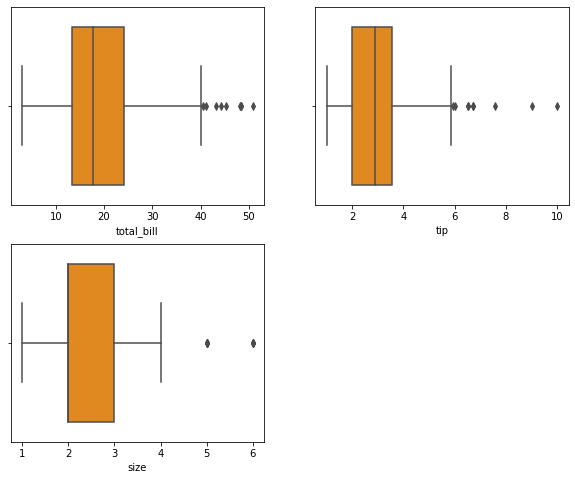

In [14]:
#check outlier
fig = plt.figure(figsize = (10,8))
axes = 220

for i in df_waiter[['total_bill', 'tip', 'size']]:
    axes += 1
    fig.add_subplot(axes)
    sns.boxplot(data = df_waiter, x = i, color = 'darkorange')
plt.show()

In [15]:
#analyze total tips based on sex, smoker and day
pd.pivot_table(df_waiter, index = ['sex', 'smoker', 'day'], values = 'tip', 
               aggfunc = {'tip' : np.sum}).sort_values('tip', ascending = False)

tip
sex    smoker day         
Male   No     Sun   133.96
              Sat   104.21
       Yes    Sat    77.74
Female No     Thur   61.49
Male   No     Thur   58.83
       Yes    Sun    52.82
Female No     Sun    46.61
       Yes    Sat    43.03
       No     Sat    35.42
Male   Yes    Thur   30.58
              Fri    21.93
Female Yes    Thur   20.93
              Fri    18.78
              Sun    14.00
       No     Fri     6.25
Male   No     Fri     5.00

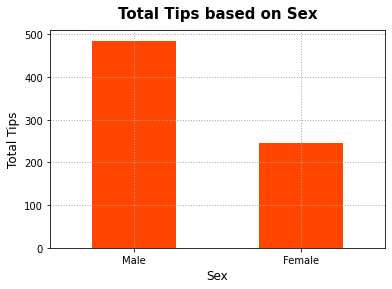

In [16]:
#visualize total tips based on sex, smoker and day
chart = df_waiter.groupby('sex')['tip'].sum().sort_values(ascending = False).plot(kind = 'bar', color = 'orangered')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 0)
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
plt.title('Total Tips based on Sex', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Sex', fontsize = 12)
plt.ylabel('Total Tips', fontsize = 12)
plt.show()

In [17]:
#analyze total tips based on time, smoker and day
pd.pivot_table(df_waiter, index = ['time', 'smoker', 'day'], values = 'tip', 
               aggfunc = {'tip' : np.sum}).sort_values('tip', ascending = False)

tip
time   smoker day         
Dinner No     Sun   180.57
              Sat   139.63
       Yes    Sat   120.77
Lunch  No     Thur  117.32
Dinner Yes    Sun    66.82
Lunch  Yes    Thur   51.51
Dinner Yes    Fri    27.03
Lunch  Yes    Fri    13.68
Dinner No     Fri     8.25
              Thur    3.00
Lunch  No     Fri     3.00

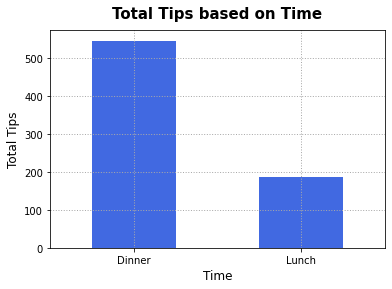

In [18]:
#visualize total tips based on time, smoker and day
chart = df_waiter.groupby('time')['tip'].sum().sort_values(ascending = False).plot(kind = 'bar', color = 'royalblue')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 0)
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
plt.title('Total Tips based on Time', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Total Tips', fontsize = 12)
plt.show()

In [19]:
#analyze total tips based on day, sex and smoker
pd.pivot_table(df_waiter, index = ['day', 'sex', 'smoker'], values = 'tip', 
               aggfunc = {'tip' : np.sum}).sort_values('tip', ascending = False)

tip
day  sex    smoker        
Sun  Male   No      133.96
Sat  Male   No      104.21
            Yes      77.74
Thur Female No       61.49
     Male   No       58.83
Sun  Male   Yes      52.82
     Female No       46.61
Sat  Female Yes      43.03
            No       35.42
Thur Male   Yes      30.58
Fri  Male   Yes      21.93
Thur Female Yes      20.93
Fri  Female Yes      18.78
Sun  Female Yes      14.00
Fri  Female No        6.25
     Male   No        5.00

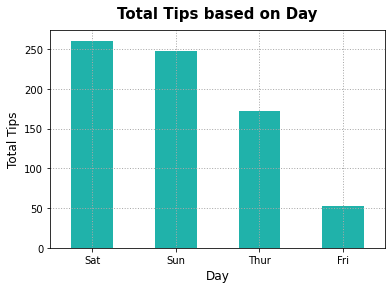

In [20]:
#visualize total tips based on day, sex and smoker
chart = df_waiter.groupby('day')['tip'].sum().sort_values(ascending = False).plot(kind = 'bar', color = 'lightseagreen')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 0)
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
plt.title('Total Tips based on Day', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Day', fontsize = 12)
plt.ylabel('Total Tips', fontsize = 12)
plt.show()

No handles with labels found to put in legend.


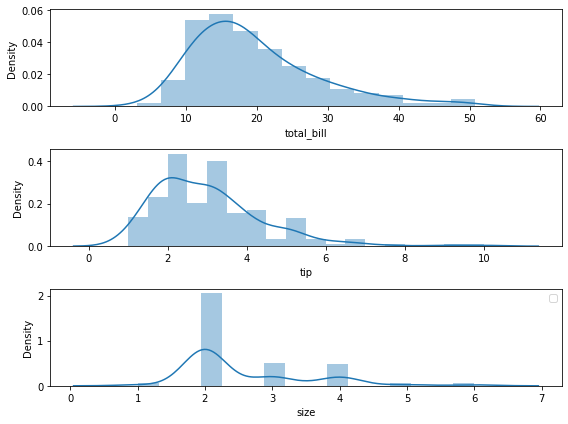

In [21]:
#visualize distribution of each variables 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (8,6))
sns.distplot(df_waiter['total_bill'], ax = ax1)
sns.distplot(df_waiter['tip'], ax = ax2)
sns.distplot(df_waiter['size'], ax = ax3)
plt.tight_layout()
plt.legend()

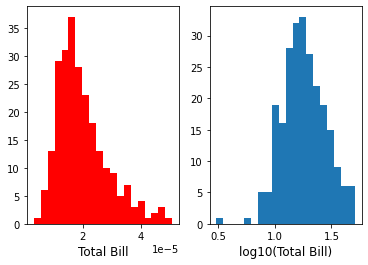

In [22]:
#transform skew distribution to normal distribution of total bill
subplot(1,2,1)
hist(df_waiter['total_bill'] * 1e-6, 20, color = 'r');
xlabel('Total Bill', fontsize = 12)
subplot(1, 2, 2)
hist(log10(df_waiter['total_bill']), 20);
xlabel('log10(Total Bill)', fontsize = 12)
plt.show()

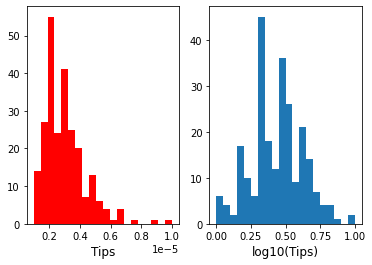

In [23]:
#transform skew distribution to normal distribution of tips
subplot(1,2,1)
hist(df_waiter['tip'] * 1e-6, 20, color = 'r');
xlabel('Tips', fontsize = 12)
subplot(1, 2, 2)
hist(log10(df_waiter['tip']), 20);
xlabel('log10(Tips)', fontsize = 12)
plt.show()

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN Clustering) 

In [24]:
#feature scaling
Clus_dataSet = df_waiter[['total_bill', 'tip', 'size']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = np.array(Clus_dataSet, dtype = np.float64)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)
print(Clus_dataSet)

[[-3.14711305e-01 -1.43994695e+00 -6.00192629e-01]
 [-1.06323531e+00 -9.69205340e-01  4.53382921e-01]
 [ 1.37779900e-01  3.63355539e-01  4.53382921e-01]
 [ 4.38315103e-01  2.25754144e-01 -6.00192629e-01]
 [ 5.40744704e-01  4.43019505e-01  1.50695847e+00]
 [ 6.19536705e-01  1.23965916e+00  1.50695847e+00]
 [-1.23995452e+00 -7.22971264e-01 -6.00192629e-01]
 [ 7.98507107e-01  8.81527488e-02  1.50695847e+00]
 [-5.34203307e-01 -7.51939979e-01 -6.00192629e-01]
 [-5.63468908e-01  1.67816714e-01 -6.00192629e-01]
 [-1.07111451e+00 -9.32994446e-01 -6.00192629e-01]
 [ 1.74175992e+00  1.44968234e+00  1.50695847e+00]
 [-4.91430507e-01 -1.03438495e+00 -6.00192629e-01]
 [-1.52624903e-01  1.24660453e-03  1.50695847e+00]
 [-5.57840908e-01  1.57309619e-02 -6.00192629e-01]
 [ 2.01939101e-01  6.67527044e-01 -6.00192629e-01]
 [-1.06436091e+00 -9.61963161e-01  4.53382921e-01]
 [-3.93503306e-01  5.15441291e-01  4.53382921e-01]
 [-3.16962505e-01  3.63355539e-01  4.53382921e-01]
 [ 9.72582994e-02  2.54722859e-

In [25]:
#build model
db = DBSCAN(eps = 0.5, min_samples = 4).fit(Clus_dataSet)
print(db)

DBSCAN(min_samples=4)


In [26]:
#prediction
core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
print(labels)

[ 0 -1  1  0  2  2  0  2  0  0  0 -1  0  2  0  0 -1  1  1  1  0  0  0 -1
  0  2  0  0  0  0  0  2  0  2  0  1  1  1  1 -1  1  0  0  0  3  0 -1 -1
 -1  0  0  0 -1  0  2  0 -1  0  0 -1  0  0  0  2  1  1  0 -1  0  0  0  1
  0 -1  0  0  0  2  0  0  0  0 -1 -1  0 -1  0  0 -1  0  0  0  0  0  0 -1
  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1 -1  0  1  0  3  0  0  2
  0  0  0  0  0 -1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1
  0  0 -1  0  0  0  0  0  1  2  2 -1 -1  2  0  2  2  0  1  0  0  1  0  3
  0  0 -1  0 -1  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1  1 -1  1  1  0  0
  0  0  0  0  0 -1  0  0  1  0  0  0  2  1  1 -1  0  0 -1  3 -1  0 -1  0
 -1  0  0  2  0  0 -1  1  0  0  0  2  0  0  2  1  0  0  0  0  0 -1 -1 -1
  0  0  0  0]


In [27]:
#recover prediction result to dataframe
df_waiter['Clus_Db'] = labels
realClusterNum = len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))
print(df_waiter[['total_bill', 'tip', 'size']].head())
print('Number of labels : ', set(labels))

   total_bill   tip  size
0       16.99  1.01     2
1       10.34  1.66     3
2       21.01  3.50     3
3       23.68  3.31     2
4       24.59  3.61     4
Number of labels :  {0, 1, 2, 3, -1}


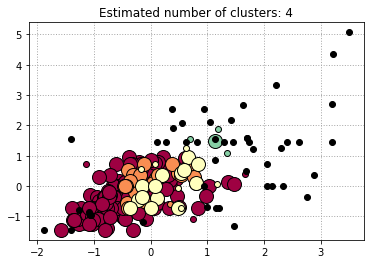

Number of noise(s) :  47


In [28]:
#visualize model
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    xy = Clus_dataSet[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor = tuple(col), markeredgecolor = 'k', markersize = 14)
    xy = Clus_dataSet[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor = tuple(col), markeredgecolor = 'k', markersize = 6)

plt.title('Estimated number of clusters: %d' % realClusterNum)
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 1)
plt.show()

n_noise = list(labels).count(-1)
print('Number of noise(s) : ', n_noise)

In [29]:
#check average attributes on each clusters
for clust_number in set(labels):
    clust_set = df_waiter[df_waiter.Clus_Db == clust_number]
    if clust_number != -1:
        print('Cluster '+str(clust_number)+', Avg Total Bill : '+str(round(np.mean(clust_set.total_bill)))+\
             ', Avg Tips : '+str(round(np.mean(clust_set['tip'])))+\
             ', Avg Size : '+str(round(np.mean(clust_set['size'])))+\
             ', Count : '+str(np.count_nonzero(clust_set.index)))

Cluster 0, Avg Total Bill : 16, Avg Tips : 2, Avg Size : 2, Count : 147
Cluster 1, Avg Total Bill : 19, Avg Tips : 3, Avg Size : 3, Count : 25
Cluster 2, Avg Total Bill : 22, Avg Tips : 3, Avg Size : 4, Count : 20
Cluster 3, Avg Total Bill : 29, Avg Tips : 5, Avg Size : 4, Count : 4


# Grocery Store

In [30]:
#load dataset
df_grocery = pd.read_csv('GroceryStoreDataSet.csv', names = ['Product'], header = None)

In [31]:
#show 5 rows ahead of dataset
df_grocery.head()

,Product
0,"MILK,BREAD,BISCUIT"
1,"BREAD,MILK,BISCUIT,CORNFLAKES"
2,"BREAD,TEA,BOURNVITA"
3,"JAM,MAGGI,BREAD,MILK"
4,"MAGGI,TEA,BISCUIT"


## Exploratory Data Analysis (EDA)

In [32]:
#check values of dataset
df_grocery.values

array([['MILK,BREAD,BISCUIT'],
       ['BREAD,MILK,BISCUIT,CORNFLAKES'],
       ['BREAD,TEA,BOURNVITA'],
       ['JAM,MAGGI,BREAD,MILK'],
       ['MAGGI,TEA,BISCUIT'],
       ['BREAD,TEA,BOURNVITA'],
       ['MAGGI,TEA,CORNFLAKES'],
       ['MAGGI,BREAD,TEA,BISCUIT'],
       ['JAM,MAGGI,BREAD,TEA'],
       ['BREAD,MILK'],
       ['COFFEE,COCK,BISCUIT,CORNFLAKES'],
       ['COFFEE,COCK,BISCUIT,CORNFLAKES'],
       ['COFFEE,SUGER,BOURNVITA'],
       ['BREAD,COFFEE,COCK'],
       ['BREAD,SUGER,BISCUIT'],
       ['COFFEE,SUGER,CORNFLAKES'],
       ['BREAD,SUGER,BOURNVITA'],
       ['BREAD,COFFEE,SUGER'],
       ['BREAD,COFFEE,SUGER'],
       ['TEA,MILK,COFFEE,CORNFLAKES']], dtype=object)

In [33]:
#apply column name to dataset
df_grocery = list(df_grocery['Product'].apply(lambda x:x.split(',')))
print(df_grocery)

[['MILK', 'BREAD', 'BISCUIT'], ['BREAD', 'MILK', 'BISCUIT', 'CORNFLAKES'], ['BREAD', 'TEA', 'BOURNVITA'], ['JAM', 'MAGGI', 'BREAD', 'MILK'], ['MAGGI', 'TEA', 'BISCUIT'], ['BREAD', 'TEA', 'BOURNVITA'], ['MAGGI', 'TEA', 'CORNFLAKES'], ['MAGGI', 'BREAD', 'TEA', 'BISCUIT'], ['JAM', 'MAGGI', 'BREAD', 'TEA'], ['BREAD', 'MILK'], ['COFFEE', 'COCK', 'BISCUIT', 'CORNFLAKES'], ['COFFEE', 'COCK', 'BISCUIT', 'CORNFLAKES'], ['COFFEE', 'SUGER', 'BOURNVITA'], ['BREAD', 'COFFEE', 'COCK'], ['BREAD', 'SUGER', 'BISCUIT'], ['COFFEE', 'SUGER', 'CORNFLAKES'], ['BREAD', 'SUGER', 'BOURNVITA'], ['BREAD', 'COFFEE', 'SUGER'], ['BREAD', 'COFFEE', 'SUGER'], ['TEA', 'MILK', 'COFFEE', 'CORNFLAKES']]


In [34]:
#feature scaling
te = TransactionEncoder()
te_df_grocery = te.fit(df_grocery).transform(df_grocery)
df_new_grocery = pd.DataFrame(te_df_grocery, columns = te.columns_)
df_new_grocery.head()

,BISCUIT,BOURNVITA,BREAD,COCK,COFFEE,CORNFLAKES,JAM,MAGGI,MILK,SUGER,TEA
0,True,False,True,False,False,False,False,False,True,False,False
1,True,False,True,False,False,True,False,False,True,False,False
2,False,True,True,False,False,False,False,False,False,False,True
3,False,False,True,False,False,False,True,True,True,False,False
4,True,False,False,False,False,False,False,True,False,False,True


In [35]:
#check total rows and columns of dataset
df_new_grocery.shape

(20, 11)

## Apriori (Association Rules)

In [36]:
#set the items and itemsets with at least 20% support 
apriori(df_new_grocery, min_support = 0.2)

,support,itemsets
0,0.35,(0)
1,0.20,(1)
2,0.65,(2)
3,0.40,(4)
4,0.30,(5)
5,0.25,(7)
6,0.25,(8)
7,0.30,(9)
8,0.35,(10)
9,0.20,"(0, 2)"


In [37]:
#convert integer values into the respective item names
apriori(df_new_grocery, min_support = 0.2, use_colnames = True)

,support,itemsets
0,0.35,(BISCUIT)
1,0.20,(BOURNVITA)
2,0.65,(BREAD)
3,0.40,(COFFEE)
4,0.30,(CORNFLAKES)
5,0.25,(MAGGI)
6,0.25,(MILK)
7,0.30,(SUGER)
8,0.35,(TEA)
9,0.20,"(BREAD, BISCUIT)"


In [38]:
#create the frequent itemsets via apriori and add new columns that stores the length of each itemset
frequent_itemsets = apriori(df_new_grocery, min_support = 0.2, use_colnames = True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
print(frequent_itemsets)

    support              itemsets  length
0      0.35             (BISCUIT)       1
1      0.20           (BOURNVITA)       1
2      0.65               (BREAD)       1
3      0.40              (COFFEE)       1
4      0.30          (CORNFLAKES)       1
5      0.25               (MAGGI)       1
6      0.25                (MILK)       1
7      0.30               (SUGER)       1
8      0.35                 (TEA)       1
9      0.20      (BREAD, BISCUIT)       2
10     0.20         (BREAD, MILK)       2
11     0.20        (BREAD, SUGER)       2
12     0.20          (BREAD, TEA)       2
13     0.20  (COFFEE, CORNFLAKES)       2
14     0.20       (COFFEE, SUGER)       2
15     0.20          (MAGGI, TEA)       2


In [39]:
#select the results that satisfy based on desired criteria
frequent_itemsets[(frequent_itemsets['length'] == 2) & (frequent_itemsets['support'] >= 0.2)]

,support,itemsets,length
9,0.2,"(BREAD, BISCUIT)",2
10,0.2,"(BREAD, MILK)",2
11,0.2,"(BREAD, SUGER)",2
12,0.2,"(BREAD, TEA)",2
13,0.2,"(COFFEE, CORNFLAKES)",2
14,0.2,"(COFFEE, SUGER)",2
15,0.2,"(MAGGI, TEA)",2


In [40]:
#select entries based on the itemsets
frequent_itemsets[frequent_itemsets['itemsets'] == {'TEA', 'BREAD'}]

,support,itemsets,length
12,0.2,"(BREAD, TEA)",2


In [41]:
#check FP-Growth for frequent pattern mining algorithm that does not require candidate generation
fpgrowth(df_new_grocery, min_support = 0.2)

,support,itemsets
0,0.65,(2)
1,0.35,(0)
2,0.25,(8)
3,0.30,(5)
4,0.35,(10)
5,0.20,(1)
6,0.25,(7)
7,0.40,(4)
8,0.30,(9)
9,0.20,"(0, 2)"


In [42]:
#convert integer values into the respective item names with FP-Growth
fpgrowth(df_new_grocery, min_support = 0.2, use_colnames = True)

,support,itemsets
0,0.65,(BREAD)
1,0.35,(BISCUIT)
2,0.25,(MILK)
3,0.30,(CORNFLAKES)
4,0.35,(TEA)
5,0.20,(BOURNVITA)
6,0.25,(MAGGI)
7,0.40,(COFFEE)
8,0.30,(SUGER)
9,0.20,"(BREAD, BISCUIT)"


In [43]:
#comparing model
print('Apriori : ')
%timeit -n 100 -r 10 apriori(df_new_grocery, min_support = 0.2)
print('FP-Growth :')
%timeit -n 100 -r 10 fpgrowth(df_new_grocery, min_support = 0.2)

Apriori : 
2.41 ms ± 188 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
FP-Growth :
1.19 ms ± 77.9 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
